先進行初步訓練 (正常資料)...
訓練開始，使用設備：cuda
[Epoch 1/50] [批次 0/15] [TS-TCC Loss: 6.4724] [Mask Loss: 0.4947] [Rec Loss: 0.8506] [WGAN G Loss: -0.0103] [Critic Loss: -0.0055]
[Epoch 2/50] [批次 0/15] [TS-TCC Loss: 6.3513] [Mask Loss: 0.3053] [Rec Loss: 0.4607] [WGAN G Loss: 0.0260] [Critic Loss: -0.0385]
[Epoch 3/50] [批次 0/15] [TS-TCC Loss: 6.1316] [Mask Loss: 0.1531] [Rec Loss: 0.3523] [WGAN G Loss: 0.0667] [Critic Loss: -0.0778]
[Epoch 4/50] [批次 0/15] [TS-TCC Loss: 6.0440] [Mask Loss: 0.0714] [Rec Loss: 0.3192] [WGAN G Loss: 0.1101] [Critic Loss: -0.1283]
[Epoch 5/50] [批次 0/15] [TS-TCC Loss: 6.0391] [Mask Loss: 0.0267] [Rec Loss: 0.3094] [WGAN G Loss: 0.1338] [Critic Loss: -0.1618]
[Epoch 6/50] [批次 0/15] [TS-TCC Loss: 6.0307] [Mask Loss: 0.0070] [Rec Loss: 0.2570] [WGAN G Loss: 0.1385] [Critic Loss: -0.1732]
[Epoch 7/50] [批次 0/15] [TS-TCC Loss: 6.0205] [Mask Loss: 0.0038] [Rec Loss: 0.2547] [WGAN G Loss: 0.1355] [Critic Loss: -0.1803]
[Epoch 8/50] [批次 0/15] [TS-TCC Loss: 6.0063] [Mask Loss: 0.0040

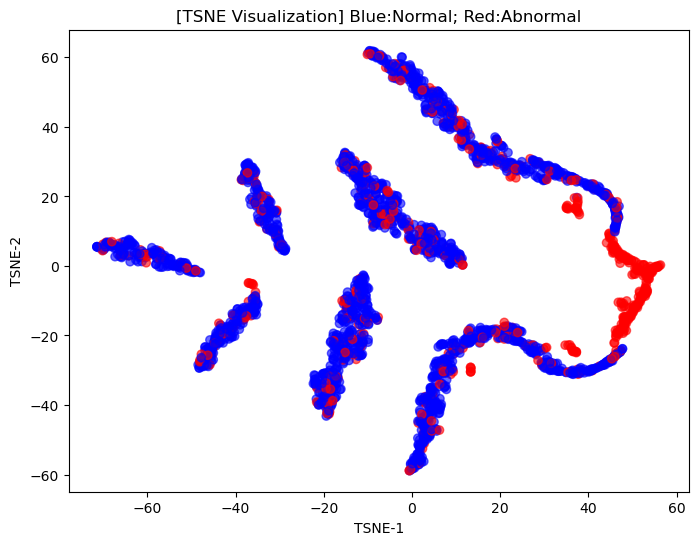

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import os
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# ===============================
# 資料集與增強方法
# ===============================
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        # data shape: (N, channels, series_length)
        if isinstance(data, np.ndarray):
            self.data = torch.from_numpy(data)
        else:
            self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

def generate_test_data(num_series=200, series_length=128, channels=1):
    test_data = []
    labels = []
    t = np.linspace(0, 2*np.pi, series_length)
    for i in range(num_series):
        series = np.sin(t) + np.random.normal(0, 0.1, series_length)
        label = 0
        if random.random() < 0.3:
            start = random.randint(0, series_length - 20)
            series[start:start+20] += np.random.normal(0, 1.0, 20)
            label = 1
        test_data.append(series.reshape(channels, series_length))
        labels.append(label)
    test_data = np.array(test_data, dtype=np.float32)
    return test_data, labels

def strong_augmentation(x, noise_std=0.05):
    """
    強增強：加入較大噪聲與隨機縮放
    """
    noise = torch.randn_like(x) * noise_std
    scale = torch.empty(x.size(0), 1, 1, device=x.device).uniform_(0.8, 1.2)
    return x * scale + noise

def weak_augmentation(x, noise_std=0.01):
    """
    弱增強：僅加入微小噪聲
    """
    noise = torch.randn_like(x) * noise_std
    return x + noise

# ===============================
# 對比損失函數
# ===============================
def nt_xent_loss(z1, z2, temperature=0.5):
    """
    z1, z2: shape [N, d]
    """
    N = z1.shape[0]
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)  # (2N, d)
    similarity_matrix = torch.matmul(representations, representations.T)
    mask = (~torch.eye(2 * N, 2 * N, dtype=bool, device=z1.device)).float()
    sim_exp = torch.exp(similarity_matrix / temperature)
    denom = torch.sum(sim_exp * mask, dim=1)
    pos_sim = torch.exp(torch.sum(z1 * z2, dim=1) / temperature)
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = -torch.log(pos_sim / (denom + 1e-8) + 1e-8)
    return loss.mean()

def temporal_contrast_loss(local_strong, local_weak, temperature=0.5):
    # local_strong, local_weak: [batch, L, d]
    batch, L, d = local_strong.size()
    strong_flat = local_strong.reshape(batch * L, d)
    weak_flat = local_weak.reshape(batch * L, d)
    return nt_xent_loss(strong_flat, weak_flat, temperature)

def contextual_contrast_loss(global_strong, global_weak, temperature=0.5):
    # global_strong, global_weak: [batch, d]
    return nt_xent_loss(global_strong, global_weak, temperature)

def ts_tcc_loss(local_strong, global_strong, local_weak, global_weak, temperature=0.5, lambda_t=0.5):
    """
    TS-TCC Loss：L = lambda_t * L_temporal + (1 - lambda_t) * L_contextual
    strong view 用於局部（temporal）對比，weak view 用於全局（contextual）對比
    """
    loss_temp = temporal_contrast_loss(local_strong, local_weak, temperature)
    loss_context = contextual_contrast_loss(global_strong, global_weak, temperature)
    return lambda_t * loss_temp + (1 - lambda_t) * loss_context

# ===============================
# 頻率模組 (Dense + Attention)
# ===============================
class LocalFrequencyModule(nn.Module):
    def __init__(self, window_size=16, stride=8, out_channels=128, attn_heads=4):
        """
        利用滑動視窗提取局部頻域特徵，並經由 dense 層與多頭注意力進行融合
        """
        super(LocalFrequencyModule, self).__init__()
        self.window_size = window_size
        self.stride = stride
        self.n_freq = window_size // 2 + 1  # FFT 後頻率分量數量
        # Dense block：兩層線性轉換
        self.dense = nn.Sequential(
            nn.Linear(self.n_freq, self.n_freq),
            nn.ReLU(),
            nn.Linear(self.n_freq, out_channels)
        )
        # 多頭自注意力 (將局部視窗作為序列)
        self.attn = nn.MultiheadAttention(embed_dim=out_channels, num_heads=attn_heads, batch_first=False)

    def forward(self, x):
        # x: [batch, channels, series_length]
        # 取得局部視窗：shape [batch, channels, n_windows, window_size]
        x_unfold = x.unfold(dimension=2, size=self.window_size, step=self.stride)
        b, c, n_windows, win = x_unfold.shape
        # 攤平至 [b*c*n_windows, window_size]
        x_unfold = x_unfold.contiguous().view(b * c * n_windows, win)
        # FFT 並取幅值：shape [b*c*n_windows, n_freq]
        freq = torch.fft.rfft(x_unfold, n=win).abs()
        # Dense block映射到 out_channels
        freq_dense = self.dense(freq)  # [b*c*n_windows, out_channels]
        # 重塑回 [b*c, n_windows, out_channels] 作為序列
        freq_seq = freq_dense.view(b * c, n_windows, -1)
        # 轉換為 [n_windows, b*c, out_channels]
        freq_seq = freq_seq.transpose(0, 1)
        # 多頭自注意力
        attn_out, _ = self.attn(freq_seq, freq_seq, freq_seq)
        # 沿 seq_len 平均：[b*c, out_channels]
        attn_mean = attn_out.mean(dim=0)
        # 重塑回 [b, channels, out_channels]
        local_freq_feature = attn_mean.view(b, c, -1)
        return local_freq_feature

class GlobalFrequencyModule(nn.Module):
    def __init__(self, series_length=128, out_channels=100, attn_heads=4, transformer_layers=1):
        """
        對整個時間序列進行 FFT 後提取全局頻域特徵，結合 dense 與 Transformer Encoder 進行特徵交互
        """
        super(GlobalFrequencyModule, self).__init__()
        self.n_freq = series_length // 2 + 1
        # 將每個頻率分量視為 token，初始 embedding 維度為 1
        self.embedding = nn.Linear(1, out_channels)
        encoder_layer = nn.TransformerEncoderLayer(d_model=out_channels, nhead=attn_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)
        self.dense = nn.Sequential(
            nn.Linear(self.n_freq * out_channels, self.n_freq * out_channels),
            nn.ReLU(),
            nn.Linear(self.n_freq * out_channels, out_channels)
        )

    def forward(self, x):
        # x: [batch, channels, series_length]
        if x.size(1) == 1:
            x = x.squeeze(1)
        else:
            x = x.mean(dim=1)
        # FFT 得到頻域表示：[batch, n_freq]
        freq = torch.fft.rfft(x, n=x.size(1)).abs()
        # 將每個頻率分量作為 token：[batch, n_freq, 1] -> [batch, n_freq, out_channels]
        tokens = self.embedding(freq.unsqueeze(-1))
        tokens = self.transformer(tokens)
        tokens_flat = tokens.flatten(start_dim=1)
        global_freq_feature = self.dense(tokens_flat)
        return global_freq_feature

# ===============================
# 時域特徵模組 (Temporal Feature Module)
# 透過 1D CNN + Transformer Encoder 如論文所示
# ===============================
class TemporalFeatureModule(nn.Module):
    def __init__(self, in_channels=1, cnn_out_channels=64, latent_dim=100, kernel_size=5, num_transformer_layers=1, attn_heads=4):
        """
        先用 1D CNN 提取局部特徵，再經由 Transformer Encoder 進行跨時間交互，最後全局平均池化與線性映射獲得時域特徵向量
        """
        super(TemporalFeatureModule, self).__init__()
        self.conv = nn.Conv1d(in_channels, cnn_out_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        encoder_layer = nn.TransformerEncoderLayer(d_model=cnn_out_channels, nhead=attn_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(cnn_out_channels, latent_dim)
    
    def forward(self, x):
        # x: [batch, channels, series_length]
        cnn_feat = self.conv(x)          # [batch, cnn_out_channels, series_length]
        cnn_feat = self.relu(cnn_feat)
        feat_seq = cnn_feat.transpose(1, 2)  # [batch, series_length, cnn_out_channels]
        trans_feat = self.transformer(feat_seq)  # [batch, series_length, cnn_out_channels]
        trans_feat = trans_feat.transpose(1, 2)   # [batch, cnn_out_channels, series_length]
        pooled = self.pool(trans_feat).squeeze(-1)  # [batch, cnn_out_channels]
        temporal_feature = self.linear(pooled)       # [batch, latent_dim]
        return temporal_feature

# ===============================
# Mask Prediction Head
# ===============================
# 此 head 將 encoder 輸出的局部特徵 (local_features_fused) 映射為預測值 (預測原始下採樣後的數值)
class MaskPredictionHead(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(MaskPredictionHead, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        # x: [batch, L, input_dim]
        return self.linear(x)  # output: [batch, L, output_dim]

# ===============================
# 模型架構：Decoder、Critic、Encoder
# ===============================
class TimeSeriesDecoder(nn.Module):
    def __init__(self, latent_dim=100, series_length=128, channels=1):
        super(TimeSeriesDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.series_length = series_length
        self.channels = channels
        self.hidden_dim = 128
        self.fc = nn.Linear(latent_dim, self.hidden_dim * (series_length // 4))
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(self.hidden_dim, self.hidden_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(self.hidden_dim // 2),
            nn.ReLU(True),
            nn.ConvTranspose1d(self.hidden_dim // 2, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.hidden_dim, self.series_length // 4)
        x = self.deconv(x)
        return x

class TimeSeriesCritic(nn.Module):
    def __init__(self, series_length=128, channels=1):
        super(TimeSeriesCritic, self).__init__()
        self.series_length = series_length
        self.channels = channels
        self.hidden_dim = 128
        self.conv = nn.Sequential(
            nn.Conv1d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(self.hidden_dim * (series_length // 4), 1)
    
    def forward(self, x):
        features = self.conv(x)
        features = features.view(features.size(0), -1)
        out = self.fc(features)
        return out

class TS_TCC_Encoder(nn.Module):
    def __init__(self, channels=1, latent_dim=100, series_length=128, local_window_size=16, local_stride=8):
        super(TS_TCC_Encoder, self).__init__()
        self.hidden_dim = 128
        # 時空間分支 (原始卷積提取局部空間特徵)
        self.conv = nn.Sequential(
            nn.Conv1d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # Global frequency module：輸出維度與 latent_dim 一致
        self.global_freq_module = GlobalFrequencyModule(series_length, out_channels=latent_dim, attn_heads=4, transformer_layers=1)
        # Local frequency module：輸出維度與 hidden_dim 一致
        self.local_freq_module = LocalFrequencyModule(window_size=local_window_size, stride=local_stride, out_channels=self.hidden_dim, attn_heads=4)
        # 時域特徵模組：1D CNN + Transformer Encoder
        self.temporal_module = TemporalFeatureModule(in_channels=channels, cnn_out_channels=64, latent_dim=latent_dim, kernel_size=5, num_transformer_layers=1, attn_heads=4)
        # 將時域與頻域特徵串接後映射成全局 latent 表徵
        self.latent_mapping = nn.Linear(2 * latent_dim, latent_dim)
        # Mask Prediction Head：將局部融合特徵映射成預測值
        self.mask_prediction_head = MaskPredictionHead(input_dim=self.hidden_dim, output_dim=1)
    
    def forward(self, x):
        # x: [batch, channels, series_length]
        # 局部空間特徵 (供對比學習)
        features = self.conv(x)                   # [batch, hidden_dim, L]
        local_features = features.permute(0, 2, 1)  # [batch, L, hidden_dim]
        # 融合 local frequency 特徵
        local_freq_feature = self.local_freq_module(x)  # [batch, channels, hidden_dim]
        local_freq_feature = local_freq_feature.squeeze(1)  # 假設 channels==1 -> [batch, hidden_dim]
        L = local_features.size(1)
        local_freq_expanded = local_freq_feature.unsqueeze(1).expand(-1, L, -1)
        local_features_fused = local_features + local_freq_expanded  # [batch, L, hidden_dim]
        # Mask prediction (下游任務)：直接從融合後的局部特徵進行預測
        mask_pred = self.mask_prediction_head(local_features_fused)  # [batch, L, 1]
        # 時域與頻域特徵萃取，用於全局表示
        temporal_feature = self.temporal_module(x)  # [batch, latent_dim]
        global_freq_feature = self.global_freq_module(x)  # [batch, latent_dim]
        concat_feature = torch.cat([temporal_feature, global_freq_feature], dim=1)  # [batch, 2*latent_dim]
        global_rep = self.latent_mapping(concat_feature)  # [batch, latent_dim]
        return local_features_fused, global_rep, mask_pred

# ===============================
# TS-TCC_WGAN 主架構：包含 TS-TCC Encoder、Decoder 與 Critic
# ===============================
class TS_TCC_WGAN:
    def __init__(self, dataset, latent_dim=100, series_length=128, channels=1, batch_size=64, lr=1e-4,
                 weight_clip=0.01, critic_iter=5, device=None, rec_loss_weight=10.0, lambda_t=0.5, mask_loss_weight=1.0):
        """
        mask_loss_weight: 下游 mask prediction loss 權重
        """
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.latent_dim = latent_dim
        self.series_length = series_length
        self.channels = channels
        self.batch_size = batch_size
        self.lr = lr
        self.weight_clip = weight_clip
        self.critic_iter = critic_iter
        self.rec_loss_weight = rec_loss_weight
        self.lambda_t = lambda_t
        self.mask_loss_weight = mask_loss_weight
        
        self.encoder = TS_TCC_Encoder(channels, latent_dim, series_length).to(self.device)
        self.decoder = TimeSeriesDecoder(latent_dim, series_length, channels).to(self.device)
        self.critic = TimeSeriesCritic(series_length, channels).to(self.device)
        
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        
        self.optim_C = optim.RMSprop(self.critic.parameters(), lr=lr)
        self.optim_E = optim.Adam(self.encoder.parameters(), lr=lr)
        self.optim_G = optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=lr)
    
    def train(self, num_epochs=100):
        print(f"訓練開始，使用設備：{self.device}")
        for epoch in range(num_epochs):
            for i, real_data in enumerate(self.dataloader):
                real_data = real_data.to(self.device)
                batch_size = real_data.size(0)
                
                # ===== TS-TCC 對比學習與 Mask Prediction =====
                strong_view = strong_augmentation(real_data)
                weak_view = weak_augmentation(real_data)
                local_strong, global_strong, _ = self.encoder(strong_view)
                local_weak, global_weak, _ = self.encoder(weak_view)
                loss_contrast = ts_tcc_loss(local_strong, global_strong, local_weak, global_weak, temperature=0.5, lambda_t=self.lambda_t)
                
                # 計算 Mask Prediction loss (下游任務)
                _, _, mask_pred = self.encoder(real_data)  # mask_pred: [batch, L, 1]
                L = mask_pred.size(1)
                # 將原始資料降採樣為目標序列
                target_seq = F.adaptive_avg_pool1d(real_data, output_size=L).squeeze(1)  # [batch, L]
                mask = (torch.rand(batch_size, L, device=self.device) < 0.15)
                if mask.sum() > 0:
                    loss_mask = F.mse_loss(mask_pred.squeeze(-1)[mask], target_seq[mask])
                else:
                    loss_mask = torch.tensor(0.0, device=self.device)
                
                total_encoder_loss = loss_contrast + self.mask_loss_weight * loss_mask
                self.optim_E.zero_grad()
                total_encoder_loss.backward(retain_graph=True)
                self.optim_E.step()
                
                # ===== 重構與 WGAN 對抗學習 =====
                _, z, _ = self.encoder(real_data)
                recon = self.decoder(z)
                rec_loss = F.l1_loss(recon, real_data)
                
                for _ in range(self.critic_iter):
                    fake = self.decoder(z.detach())
                    critic_real = self.critic(real_data)
                    critic_fake = self.critic(fake)
                    loss_C = -torch.mean(critic_real) + torch.mean(critic_fake)
                    
                    self.optim_C.zero_grad()
                    loss_C.backward()
                    self.optim_C.step()
                    
                    for p in self.critic.parameters():
                        p.data.clamp_(-self.weight_clip, self.weight_clip)
                
                fake = self.decoder(z)
                loss_G_adv = -torch.mean(self.critic(fake))
                loss_G = self.rec_loss_weight * rec_loss + loss_G_adv
                
                self.optim_G.zero_grad()
                loss_G.backward()
                self.optim_G.step()
                
                total_loss = loss_contrast.item() + self.rec_loss_weight * rec_loss.item() + loss_G_adv.item() + self.mask_loss_weight * loss_mask.item()
                if i % 50 == 0:
                    print(f"[Epoch {epoch+1}/{num_epochs}] [批次 {i}/{len(self.dataloader)}] "
                          f"[TS-TCC Loss: {loss_contrast.item():.4f}] [Mask Loss: {loss_mask.item():.4f}] "
                          f"[Rec Loss: {rec_loss.item():.4f}] [WGAN G Loss: {loss_G_adv.item():.4f}] [Critic Loss: {loss_C.item():.4f}]")
        print("訓練完成。")
    
    def reconstruct(self, x):
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad():
            _, z, _ = self.encoder(x.to(self.device))
            recon = self.decoder(z)
        self.encoder.train()
        self.decoder.train()
        return z.cpu(), recon.cpu()
    
    def get_latent(self, x):
        self.encoder.eval()
        with torch.no_grad():
            _, z, _ = self.encoder(x.to(self.device))
        self.encoder.train()
        return z.cpu()
    
    def get_model(self):
        return {"encoder": self.encoder, "decoder": self.decoder, "critic": self.critic}

# ===============================
# RLHF 部分
# ===============================
def ranking_loss(critic, preferred, non_preferred):
    score_pref = critic(preferred)
    score_nonpref = critic(non_preferred)
    loss = -torch.log(torch.sigmoid(score_pref - score_nonpref) + 1e-8)
    return loss.mean()

def rlhf_finetune(model, human_feedback, num_epochs=5, lambda_factor=0.5):
    device = model.device
    optimizer = optim.Adam(list(model.encoder.parameters()) + 
                           list(model.decoder.parameters()) + 
                           list(model.critic.parameters()), lr=model.lr)
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for fb in human_feedback:
            sample1 = fb["sample1"].detach().clone().to(device).unsqueeze(0)
            sample2 = fb["sample2"].detach().clone().to(device).unsqueeze(0)
            if fb["preferred"] == 1:
                pos_sample = sample1
                neg_sample = sample2
            elif fb["preferred"] == 2:
                pos_sample = sample2
                neg_sample = sample1
            else:
                raise ValueError("preferred 欄位必須為 1 或 2")
            
            pos_aug = strong_augmentation(pos_sample)
            local_pos, global_pos, _ = model.encoder(pos_sample)
            local_pos_aug, global_pos_aug, _ = model.encoder(pos_aug)
            contrast_loss = ts_tcc_loss(local_pos, global_pos, local_pos_aug, global_pos_aug, temperature=0.5, lambda_t=0.5)
            
            r_loss = ranking_loss(model.critic, pos_sample, neg_sample)
            total_batch_loss = lambda_factor * r_loss + (1 - lambda_factor) * contrast_loss
            
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()
            
            total_loss += total_batch_loss.item()
        avg_loss = total_loss / len(human_feedback)
        print(f"[RLHF Epoch {epoch+1}/{num_epochs}] 平均損失: {avg_loss:.4f}")
    print("RLHF 微調完成。")

# ===============================
# 輔助函數：建模、CSV 資料生成與載入、TSNE 視覺化
# ===============================
def build_ts_tcc_wgan_model(dataset, latent_dim=100, series_length=128, channels=1, batch_size=64, lr=1e-4,
                            weight_clip=0.01, critic_iter=5, device=None, rec_loss_weight=10.0, lambda_t=0.5, mask_loss_weight=1.0):
    model = TS_TCC_WGAN(dataset, latent_dim=latent_dim, series_length=series_length, channels=channels,
                          batch_size=batch_size, lr=lr, weight_clip=weight_clip, critic_iter=critic_iter,
                          device=device, rec_loss_weight=rec_loss_weight, lambda_t=lambda_t, mask_loss_weight=mask_loss_weight)
    return model

def generate_pair_data_csv(model, num_pairs=20, csv_path='pair_data.csv'):
    device = model.device
    latent_dim = model.latent_dim
    pair_list = []
    for i in range(num_pairs):
        z1 = torch.randn(1, latent_dim, device=device)
        z2 = torch.randn(1, latent_dim, device=device)
        sample1 = model.decoder(z1)
        sample2 = model.decoder(z2)
        sample1_mean = sample1.abs().mean().item()
        sample2_mean = sample2.abs().mean().item()
        preferred = 1 if sample1_mean > sample2_mean else 2
        pair_list.append({
            'pair_id': i,
            'sample1_mean': sample1_mean,
            'sample2_mean': sample2_mean,
            'preferred': preferred
        })
    df = pd.DataFrame(pair_list)
    df.to_csv(csv_path, index=False)
    print(f"Pair data 已儲存至 {csv_path}")
    return df

def load_human_feedback_from_csv(csv_path='pair_data.csv', model=None):
    df = pd.read_csv(csv_path)
    human_feedback = []
    latent_dim = model.latent_dim
    device = model.device
    for idx, row in df.iterrows():
        z1 = torch.randn(1, latent_dim, device=device)
        z2 = torch.randn(1, latent_dim, device=device)
        sample1 = model.decoder(z1).squeeze(0).cpu()
        sample2 = model.decoder(z2).squeeze(0).cpu()
        feedback = {"sample1": sample1, "sample2": sample2, "preferred": int(row['preferred'])}
        human_feedback.append(feedback)
    return human_feedback

def tsne_visualize(model, test_data, labels, window_size=32, stride=8):
    model.encoder.eval()
    all_latents = []
    all_colors = []
    expected_length = model.series_length
    for i in range(test_data.shape[0]):
        ts = torch.from_numpy(test_data[i]).unsqueeze(0)
        for start in range(0, ts.shape[-1]-window_size+1, stride):
            window = ts[:, :, start:start+window_size].to(model.device)
            if window.shape[-1] != expected_length:
                window = torch.nn.functional.interpolate(window, size=expected_length, mode='linear', align_corners=False)
            _, z, _ = model.encoder(window)
            all_latents.append(z.squeeze(0).detach().cpu().numpy())
            all_colors.append('red' if labels[i]==1 else 'blue')
    all_latents = np.array(all_latents)
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(all_latents)
    
    plt.figure(figsize=(8,6))
    plt.scatter(latent_2d[:,0], latent_2d[:,1], c=all_colors, alpha=0.6)
    plt.title("[TSNE Visualization] Blue:Normal; Red:Abnormal")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.show()
    model.encoder.train()

# ===============================
# 主程式入口
# ===============================
if __name__ == '__main__':
    # (1) 產生訓練資料：模擬正常時間序列
    num_train = 1000
    series_length = 128
    channels = 1
    t = np.linspace(0, 2*np.pi, series_length)
    train_data = []
    for _ in range(num_train):
        series = np.sin(t) + np.random.normal(0, 0.1, series_length)
        train_data.append(series.reshape(channels, series_length))
    train_data = np.array(train_data, dtype=np.float32)
    train_dataset = TimeSeriesDataset(train_data)
    
    # (2) 建立模型並以正常資料訓練
    model = build_ts_tcc_wgan_model(train_dataset, latent_dim=100, series_length=series_length,
                                     channels=channels, batch_size=64, lr=1e-4)
    print("先進行初步訓練 (正常資料)...")
    model.train(num_epochs=50)
    
    # (3) 生成 pair 資料並存 CSV（供 human feedback 標記）
    csv_path = 'pair_data.csv'
    generate_pair_data_csv(model, num_pairs=20, csv_path=csv_path)
    
    # (4) 讀取 CSV 並進行 RLHF 微調
    human_feedback = load_human_feedback_from_csv(csv_path, model=model)
    print("開始 RLHF 微調...")
    rlhf_finetune(model, human_feedback, num_epochs=3, lambda_factor=0.5)
    
    # (5) 產生測試資料（正常與異常）
    test_data, test_labels = generate_test_data(num_series=200, series_length=series_length, channels=channels)
    
    # (6) 使用 TSNE 降維視覺化測試資料的 latent 分布
    tsne_visualize(model, test_data, test_labels, window_size=32, stride=8)
